In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


# 波士顿房价数据集
此数据集可以直接在 TensorFlow 中访问。下载并随机化处理训练集：

In [3]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

57344/57026 [==============================] - 0s 6us/step


## 样本和特征
此数据集比我们到目前为止使用的其他数据集小得多：它共有 506 个样本，拆分为 404 个训练样本和 102 个测试样本：

In [4]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


该数据集包含 13 个不同的特征：

1. 人均犯罪率。
2. 占地面积超过 25000 平方英尺的住宅用地所占的比例。
3. 非零售商业用地所占的比例（英亩/城镇）。
4. 查尔斯河虚拟变量（如果大片土地都临近查尔斯河，则为 1；否则为 0）。
5. 一氧化氮浓度（以千万分之一为单位）。
6. 每栋住宅的平均房间数。
7. 1940 年以前建造的自住房所占比例。
8. 到 5 个波士顿就业中心的加权距离。
9. 辐射式高速公路的可达性系数。
10. 每 10000 美元的全额房产税率。
11. 生师比（按城镇统计）。
12. 1000 * (Bk - 0.63) ** 2，其中 Bk 是黑人所占的比例（按城镇统计）。
13. 较低经济阶层人口所占百分比。
以上每个输入数据特征都有不同的范围。一些特征用介于 0 到 1 之间的比例表示，另外一些特征的范围在 1 到 12 之间，还有一些特征的范围在 0 到 100 之间，等等。真实的数据往往都是这样，了解如何探索和清理此类数据是一项需要加以培养的重要技能。

要点：作为建模者兼开发者，需要考虑如何使用这些数据，以及模型预测可能会带来哪些潜在益处和危害。类似这样的模型可能会加深社会偏见，扩大社会差异。某个特征是否与您想要解决的问题相关，或者是否会引入偏见？要了解详情，请参阅机器学习公平性。

In [5]:
print(train_data[0])  # Display sample features, notice the different scales

[7.8750e-02 4.5000e+01 3.4400e+00 0.0000e+00 4.3700e-01 6.7820e+00
 4.1100e+01 3.7886e+00 5.0000e+00 3.9800e+02 1.5200e+01 3.9387e+02
 6.6800e+00]


In [7]:
# 使用 Pandas 库在格式规范的表格中显示数据集的前几行：
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


## 标签
标签是房价（以千美元为单位）。（您可能会注意到 20 世纪 70 年代中期的房价。）

In [8]:
print(train_labels[0:10])  # Display first 10 entries

[32.  27.5 32.  23.1 50.  20.6 22.6 36.2 21.8 19.5]


## 数据正则化处理
作用是消除不同量纲的影响
建议标准化使用不同比例和范围的特征。对于每个特征，用原值减去特征的均值，再除以标准偏差即可：


In [9]:
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39725269  1.41205707 -1.12664623 -0.25683275 -1.027385    0.72635358
 -1.00016413  0.02383449 -0.51114231 -0.04753316 -1.49067405  0.41584124
 -0.83648691]


虽然在未进行特征标准化的情况下，模型可能会收敛，但这样做会增加训练难度，而且使生成的模型更加依赖于在输入中选择使用的单位。

# 创建模型
我们来构建模型。在此教程中，我们将使用 Sequential 模型，该模型包含两个密集连接隐藏层，以及一个返回单个连续值的输出层。由于我们稍后要再创建一个模型，因此将模型构建步骤封装在函数 build_model 中。

In [10]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


# 训练模型
对该模型训练 500 个周期，并将训练和验证准确率记录到 history 对象中。

In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

使用存储在 history 对象中的统计数据可视化模型的训练进度。我们希望根据这些数据判断：对模型训练多长时间之后它会停止优化。

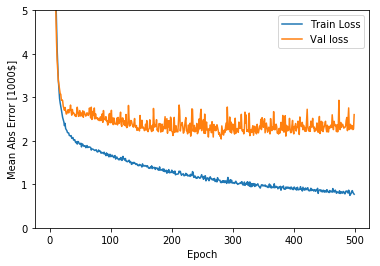

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

此图显示，在大约 200 个周期之后，模型几乎不再出现任何改进。我们更新一下 model.fit 方法，以便在验证分数不再提高时自动停止训练。我们将使用一个回调来测试每个周期的训练状况。如果模型在一定数量的周期之后没有出现任何改进，则自动停止训练。


....................................................................................................
........................................

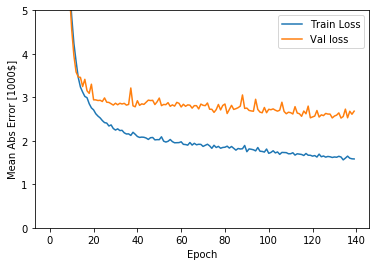

In [13]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

此图显示平均误差约为 2500 美元。这是一个出色的模型吗？如果某些标签只是 15000 美元，那么 2500 美元的误差也不算小。

现在看一下模型在测试集上的表现如何：

In [14]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2730.28


# 预测

最后，使用测试集中的数据预测某些房价：

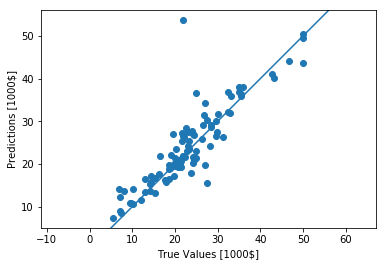

In [15]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

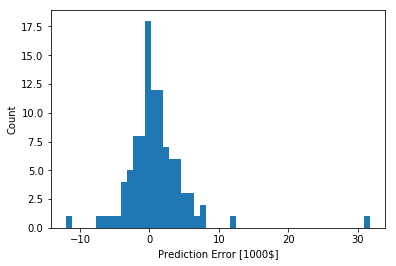

In [16]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

# 总结
此笔记本介绍了几个处理回归问题的技巧。

* 均方误差 (MSE) 是用于回归问题的常见损失函数（与分类问题不同）。
* 同样，用于回归问题的评估指标也与分类问题不同。常见回归指标是平均绝对误差 (MAE)。
* 如果输入数据特征的值具有不同的范围，则应分别缩放每个特征。
* 如果训练数据不多，则选择隐藏层较少的小型网络，以避免出现过拟合。
* 早停法是防止出现过拟合的实用技术。